In [88]:
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
expert = DQN("MlpPolicy", "CartPole-v1", device = "cuda").learn(10000)

In [6]:
import numpy as np
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy

from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env

rng = np.random.default_rng(0)
env = make_vec_env("CartPole-v1", rng=rng, n_envs=1, post_wrappers=[lambda env, _: RolloutInfoWrapper(env)])  # for computing rollouts

rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
)
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


44batch [00:00, 134.85batch/s]


Reward: 50.2


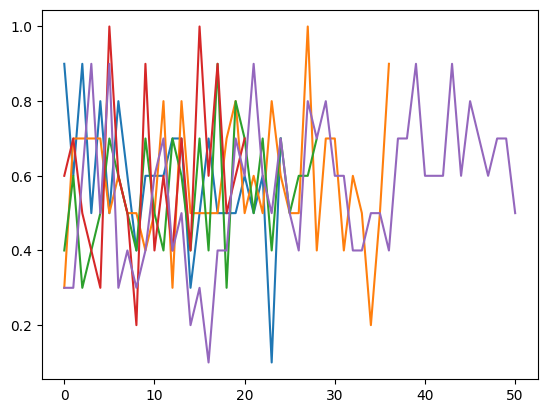

In [104]:
import random

rewards = []
for __ in range(5):
    trajectory = random.sample(rollouts, 1)[0]
    simRew = []
    for _ in range(10):
        action, _ = bc_trainer.policy.predict(trajectory.obs[:-1])
        simRew.append((action == trajectory.acts).astype(int))
    rewards.append(np.stack(simRew).mean(0))

for x in rewards:
    plt.plot(x)